In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from pycocotools.coco import COCO
import random
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
moth_path = '/content/drive/MyDrive/moths redo/cropped/'
moth_samples = [name for name in os.listdir(moth_path) if os.path.isfile(os.path.join(moth_path, name))]
print(f"found {len(moth_samples)} files")

found 967 files


Imports related to actual training

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:

def extract_labels(filepath):
    # Extract the filename (excluding the path)
    filename = filepath.split('/')[-1]
    parts = filename.split('.')

    # Ensure the filename has the expected format
    if len(parts) > 2:
        scientific_name = parts[2]  # Scientific name (e.g., Biston-betularia-cognataria)
        return scientific_name
    else:
        return "Unknown"

# Create DataFrames with only scientific name as the label
def create_dataframe(file_list):
    data = []
    for filepath in file_list:
        scientific_name = extract_labels(filepath)
        data.append({
            'filename': filepath,
            'scientific_name': scientific_name
        })
    return pd.DataFrame(data)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import os

# Create DataFrame for all samples
moth_data = create_dataframe([os.path.abspath(moth_path) + "/" + filepath for filepath in moth_samples])

# Filter species with at least 10 samples
moth_data = moth_data[moth_data.groupby('scientific_name').scientific_name.transform('count') >= 5]
total_species = moth_data['scientific_name'].nunique()

print(f"Total number of meaningful species (>=10 samples): {total_species}")

# Adjust test_size for the initial split (e.g., increase temp size)
train_size = 0.7
validate_size = .25
test_size = .05

initial_test_size = validate_size + test_size + 0.05  # Slightly increase total temp size
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=initial_test_size, random_state=0)

for train_idx, temp_idx in strat_split.split(moth_data, moth_data['scientific_name']):
    moth_train = moth_data.iloc[train_idx]
    temp_samples = moth_data.iloc[temp_idx]

# Adjust test_size for the secondary split (e.g., increase test proportion)
secondary_test_size = (test_size / (validate_size + test_size)) + 0.05  # Slightly increase test size
strat_split_temp = StratifiedShuffleSplit(n_splits=1, test_size=secondary_test_size, random_state=5)

for val_idx, test_idx in strat_split_temp.split(temp_samples, temp_samples['scientific_name']):
    moth_validate = temp_samples.iloc[val_idx]
    moth_test = temp_samples.iloc[test_idx]

# Print results
print(f"Training files: {len(moth_train)}")
print(f"Validation files: {len(moth_validate)}")
print(f"Testing files: {len(moth_test)}")


Total number of meaningful species (>=10 samples): 45
Training files: 469
Validation files: 198
Testing files: 55


In [ ]:
species_counts = moth_data['scientific_name'].value_counts()
pd.set_option('display.max_rows', len(species_counts))
# Print the total list
print("Number of samples for each species:")
print(species_counts)
pd.reset_option('display.max_rows')

Number of samples for each species:
scientific_name
Eudonia-heterosalis            150
Blastobasis-glandulella         48
Psilocorsis-reflexella          43
Dryocampa-rubicunda             36
Actias-luna                     31
Drepana-arcuata                 26
Peridea-ferruginea              25
Nadata-gibbosa                  23
Gluphisia-septentrionis         22
Idia-rotundalis                 21
Euchlaena-tigrinaria            14
Lymantria-dispar                14
Eudonia-strigalis               14
Hyperaeschra-georgica           14
Cecrita-guttivitta              13
Phyllodesma-americana           12
Lambdina-fiscellaria            11
Campaea-perlata                 11
Spilosoma-latipennis            11
Zanclognatha-jacchusalis        11
Macaria-pustularia              10
Scoparia-biplagialis            10
Biston-betularia-cognataria      9
Peridea-basitriens               9
Zanclognatha-laevigata           9
Pandemis-limitata                8
Hydrelia-inornata                8
Cle

In [ ]:
assert set(moth_train['scientific_name']) == set(moth_validate['scientific_name']) == set(moth_test['scientific_name']), "Class sets do not match!"
#== set(moth_test['scientific_name']), "Class sets do not match!"
m1 = set(moth_train['scientific_name']) - set(moth_test['scientific_name'])
m2 = set(moth_validate['scientific_name']) - set(moth_test['scientific_name'])
print(m1, m2)

set() set()


In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,  # Randomly flip images
    vertical_flip=True,
    fill_mode='nearest'  # Fill missing pixels after transformations
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize for validation/test

# Create generators for multi-class classification with only scientific_name
train_generator = train_datagen.flow_from_dataframe(
    dataframe=moth_train,
    x_col='filename',
    y_col='scientific_name',  # Only 'scientific_name' as the label
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_mode='sparse'  # Use sparse if labels are integers
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=moth_validate,
    x_col='filename',
    y_col='scientific_name',  # Only 'scientific_name' as the label
    target_size=(224, 224),
    batch_size=64,
    shuffle=False,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=moth_test,
    x_col='filename',
    y_col='scientific_name',  # Only 'scientific_name' as the label
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

# Print unique labels in the scientific name column
print("Unique scientific names in train_data:")
print(len(moth_train['scientific_name'].unique()))

print("Unique scientific names in validate_data:")
print(len(moth_validate['scientific_name'].unique()))

print("Unique scientific names in test_data:")
print(len(moth_test['scientific_name'].unique()))

# Print unique scientific names (optional)
#print("Unique scientific names in train_data:")
#print(train_data_filtered['scientific_name'].unique())



Found 370 validated image filenames belonging to 22 classes.
Found 156 validated image filenames belonging to 22 classes.
Found 44 validated image filenames belonging to 22 classes.
Unique scientific names in train_data:
22
Unique scientific names in validate_data:
22
Unique scientific names in test_data:
22


In [ ]:
class_indices = train_generator.class_indices  # Dictionary: {'class_name': index}
ordered_classes = [class_name for class_name, _ in sorted(class_indices.items(), key=lambda item: item[1])]

print("Classes in training order:")
print(ordered_classes)

Classes in training order:
['Actias-luna', 'Blastobasis-glandulella', 'Campaea-perlata', 'Cecrita-guttivitta', 'Drepana-arcuata', 'Dryocampa-rubicunda', 'Euchlaena-tigrinaria', 'Eudonia-heterosalis', 'Eudonia-strigalis', 'Gluphisia-septentrionis', 'Hyperaeschra-georgica', 'Idia-rotundalis', 'Lambdina-fiscellaria', 'Lymantria-dispar', 'Macaria-pustularia', 'Nadata-gibbosa', 'Peridea-ferruginea', 'Phyllodesma-americana', 'Psilocorsis-reflexella', 'Scoparia-biplagialis', 'Spilosoma-latipennis', 'Zanclognatha-jacchusalis']


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load EfficientNetB0 as the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = layers.Dense(128, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
output = layers.Dense(22, activation='softmax')(x)  # Output layer for 22 classes

# Define the model
model = models.Model(inputs=base_model.input, outputs=output)

# Freeze the base model during initial training
base_model.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.save("/content/drive/MyDrive/moths redo/models/87imagenet.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/moths redo/models/75imagenet.keras")

In [ ]:

model2 = load_model("/content/drive/MyDrive/moths redo/models/87imagenet.keras")
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,758,404 (10.52 MB)

 Trainable params: 166,806 (651.59 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 333,614 (1.27 MB)

In [ ]:
assert set(train_data['scientific_name'].unique()) == set(validate_data['scientific_name'].unique())


NameError: name 'train_data' is not defined

In [ ]:
print(moth_validate['scientific_name'].value_counts())


scientific_name
Eudonia-heterosalis         34
Blastobasis-glandulella     11
Psilocorsis-reflexella      10
Dryocampa-rubicunda          8
Actias-luna                  7
Peridea-ferruginea           6
Drepana-arcuata              6
Idia-rotundalis              5
Gluphisia-septentrionis      5
Nadata-gibbosa               5
Zanclognatha-jacchusalis     3
Lymantria-dispar             3
Hyperaeschra-georgica        3
Cecrita-guttivitta           3
Euchlaena-tigrinaria         3
Phyllodesma-americana        3
Eudonia-strigalis            3
Spilosoma-latipennis         2
Macaria-pustularia           2
Lambdina-fiscellaria         2
Scoparia-biplagialis         2
Campaea-perlata              2
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.6996 - loss: 1.0688 - val_accuracy: 0.7500 - val_loss: 1.0272 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7009 - loss: 1.1565 - val_accuracy: 0.7734 - val_loss: 1.0245 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6839 - loss: 1.1367 - val_accuracy: 0.7891 - val_loss: 1.0118 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7448 - loss: 1.0259 - val_accuracy: 0.7812 - val_loss: 0.9944 - learning_rate: 1.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6951 - loss: 1.1638 - val_accuracy: 0.7656 - val_loss: 0.9852 - learning_rate: 1.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7141 - loss: 1.1095 - val_accuracy: 0.7891 - val_loss: 0.9729 - learning_rate: 1.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7484 - loss: 0.9434

In [ ]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# Assuming `model` is already trained and `val_generator` is your validation/test set
for i in range(1, 6):
  top_k_metric = TopKCategoricalAccuracy(k=i)
  predictions = model.predict(val_generator)  # Get model predictions
  true_labels = val_generator.classes  # True labels from generator

  # Update the metric with predictions and true labels
  top_k_metric.update_state(tf.one_hot(true_labels, depth=predictions.shape[1]), predictions)

  # Compute top-k accuracy
  top_k_accuracy = top_k_metric.result().numpy()
  print(f"Top-{i} Accuracy: {top_k_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
Top-1 Accuracy: 0.8672
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
Top-2 Accuracy: 0.9297
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
Top-3 Accuracy: 0.9688
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
Top-4 Accuracy: 0.9922
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
Top-5 Accuracy: 1.0000


In [ ]:
import math

def plot_predictions(images, true_labels, predictions, class_labels, k=5, num_images=5):
    num_rows = math.ceil(num_images / 5)
    plt.figure(figsize=(15, num_rows * 3))

    for i in range(num_images):
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        # Extract true label and Top-k predictions
        true_class = class_labels[true_labels[i]]
        top_k_indices = np.argsort(predictions[i])[-k:]  # Get indices of top-k predictions
        top_k_classes = [class_labels[idx] for idx in reversed(top_k_indices)]
        top_k_text = '\n'.join(top_k_classes)  # Combine items with newline

        # Highlight if Top-1 is correct
        pred_class = top_k_classes[0]
        color = 'green' if true_class == pred_class else 'red'

        # Add title with True label and Top-k predictions
        plt.title(f"True: {true_class}\nTop-{k}:\n{top_k_text}", color=color)

    plt.tight_layout()
    fig = plt.gcf()
    return fig, plt
    #plt.savefig('mo.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
    #plt.show()


In [ ]:
images, labels = next(test_generator)
predictions = model.predict(images)
class_labels = {v: k for k, v in val_generator.class_indices.items()}


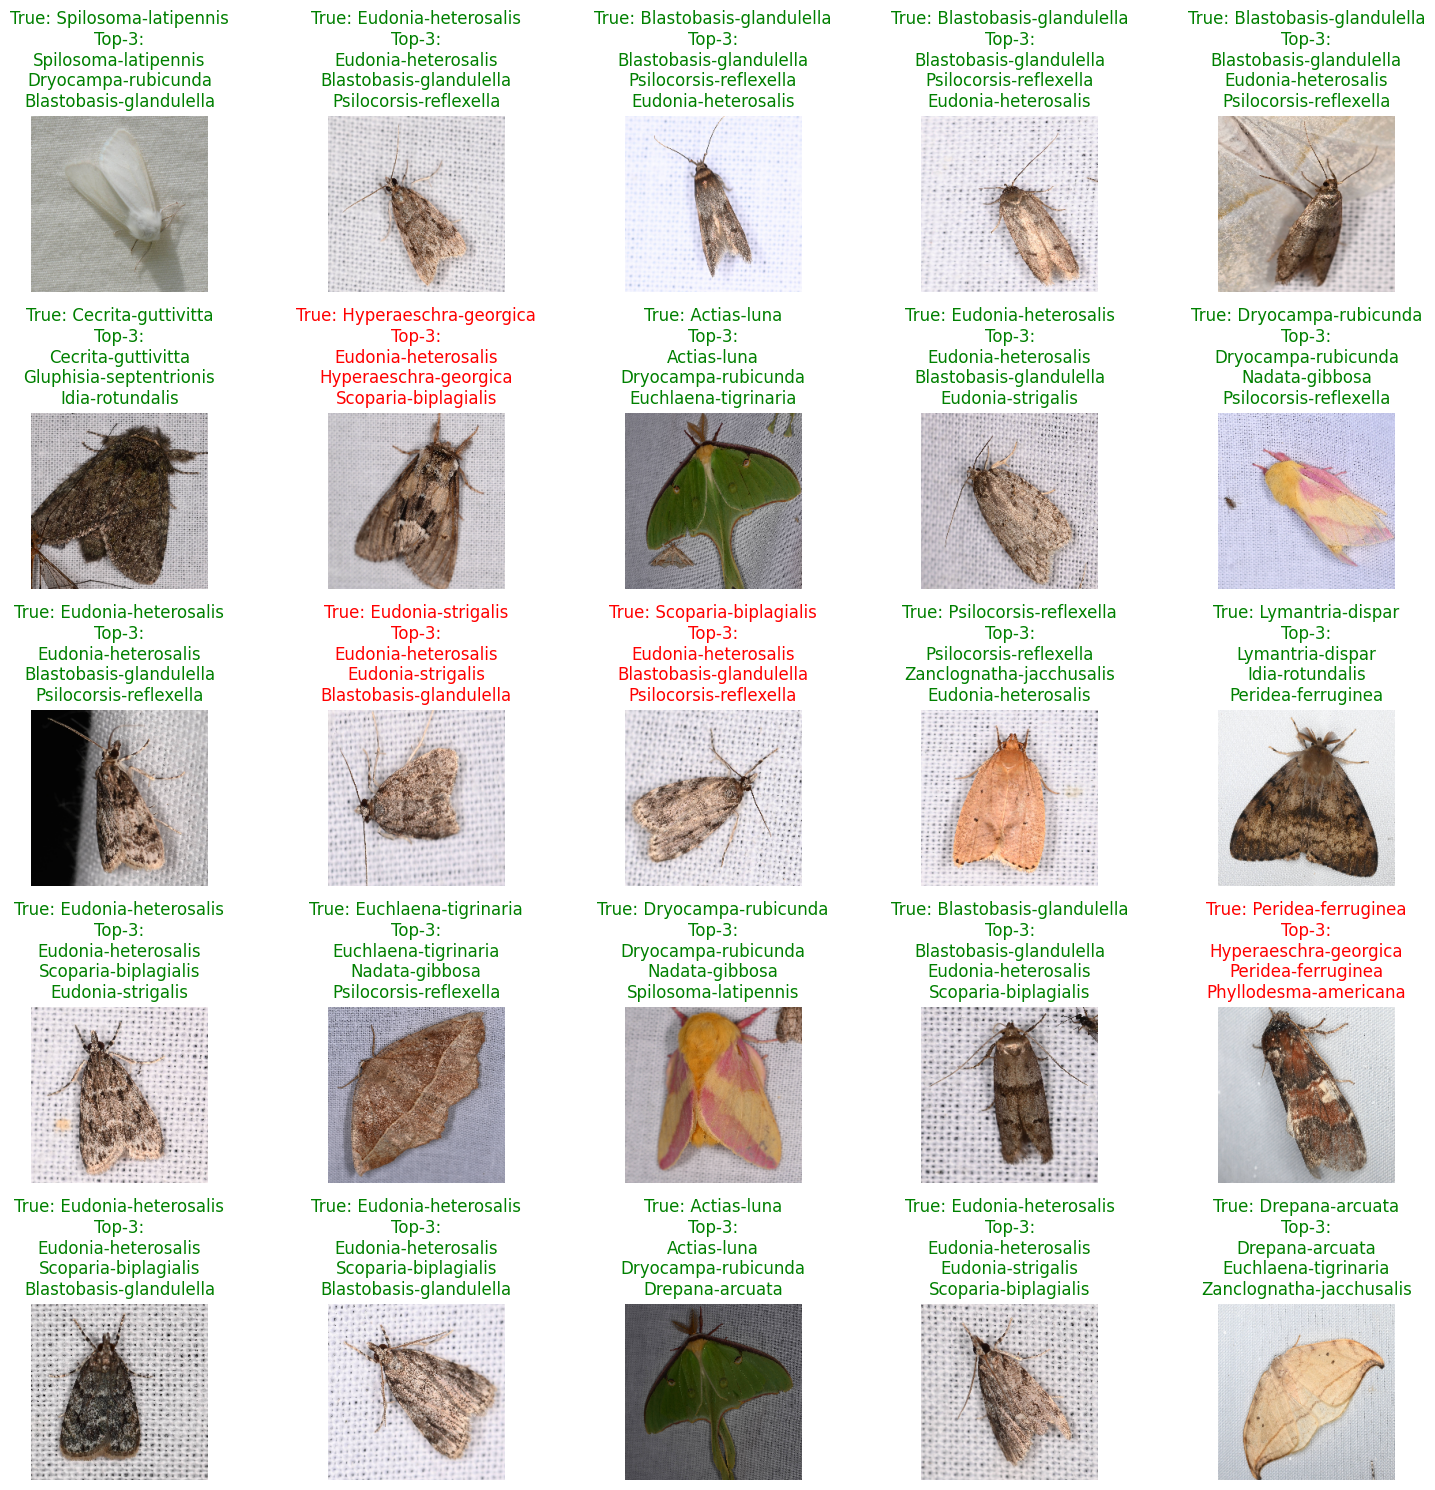

In [ ]:
fig, plt = plot_predictions(images, labels, predictions, class_labels, k=3, num_images=25)

fig.show()

In [ ]:
fig.savefig('moths!.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>